# 1. Introduction

- Datenanalyse für das Data Mining Projekt "Schwerpunktländer für Klimaschutz und Biodiversitätserhalt 
- Thematischer Fokus der Analyse: Identifikation von potentiellen Schwerpunktländern in Subsahara-Afrika basierend auf Klassifikationsmodellen 



# 2. Preparation

### 2.1 Import packages

In [ ]:
import os
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
from descartes import PolygonPatch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport


# 3. Data

### 3.1 Data collection (import)

In [9]:
# define path
CSV_PATH = os.path.join("input","country_data.csv")
print(CSV_PATH)

input\country_data.csv


In [10]:
#import csv file
df = pd.read_csv(CSV_PATH, sep=";")
df.shape

(140, 18)

## 3.2 Data profiling 

In [ ]:
profile = ProfileReport(df)
profile.to_file("country_data_report.html")

## 3.2 Preprocessing Data 

In [26]:
# Subset Dataframe: Sub-Saharan African countries 
ssa_df = df[df['SubregionName'].str.contains("Sub-Saharan Africa") == True]
ssa_df.shape

(48, 18)

In [20]:
# Subset Dataframe: non-Sub-Saharan African countries 
other_df = df[df['SubregionName'].str.contains("Sub-Saharan Africa") == False]
other_df.shape


(92, 18)

In [23]:
# Subset Dataframe: African countries 
africa_df = df[df['RegionName'].str.contains("Africa") == True]
africa_df.shape

(54, 18)

In [29]:
other_df.dtypes

CountryCode                     object
CountryName                     object
RegionName                      object
SubregionName                   object
LDC                              int64
LLDC                             int64
SIDS                             int64
Density(P/Km2)                 float64
LandArea(Km2)                  float64
GDP                            float64
Population                     float64
Urban_population               float64
Fragility_State_Index_Clean    float64
GHG_Emissions_2020             float64
GHG_Emissions_1990             float64
EPI.new                        float64
SUM(KBAArea)                   float64
IKIPriorityCountry               int64
dtype: object

### 3.2.1 Missing Data

In [ ]:
# Identify missing data
print(other_df.isna().sum().sort_values())

CountryCode                     0
SIDS                            0
LLDC                            0
LDC                             0
IKIPriorityCountry              0
RegionName                      0
CountryName                     0
SubregionName                   0
SUM(KBAArea)                    1
GHG_Emissions_2020              4
GHG_Emissions_1990              4
Density(P/Km2)                  5
GDP                             6
Population                      6
LandArea(Km2)                   6
Urban_population                8
EPI.new                        12
Fragility_State_Index_Clean    16
dtype: int64


In [34]:
# Splitting data (non-Sub-Saharan African countries)
X = other_df.drop(['CountryCode', 'CountryName', 'RegionName', 'SubregionName', 'IKIPriorityCountry'], axis= 1).values
y = other_df["IKIPriorityCountry"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


# Imputation with scikit-learn
imp_num = SimpleImputer ()
X_train = imp_num.fit_transform(X_train)
X_test = imp_num.transform(X_test) 



numpy.ndarray

In [ ]:
# Creating NumpyArray Sub-Saharan African countries  
X_new = ssa_df.drop(['CountryCode', 'CountryName', 'RegionName', 'SubregionName', 'IKIPriorityCountry'], axis= 1).values

# Imputation with scikit-learn 
imp_num = SimpleImputer ()
X_new = imp_num.fit_transform(X_new)
X_new = imp_num.transform(X_new) 



In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_new.shape)

(73, 13)
(73,)
(19, 13)
(19,)
(48, 13)


### 3.2.1 Scaling Data

In [ ]:
print(other_df.keys())

Index(['CountryCode', 'CountryName', 'RegionName', 'SubregionName', 'LDC',
       'LLDC', 'SIDS', 'Density(P/Km2)', 'LandArea(Km2)', 'GDP', 'Population',
       'Urban_population', 'Fragility_State_Index_Clean', 'GHG_Emissions_2020',
       'GHG_Emissions_1990', 'EPI.new', 'SUM(KBAArea)', 'IKIPriorityCountry'],
      dtype='object')


In [ ]:
print(other_df[['LDC', 'LLDC', 'SIDS', 'Density(P/Km2)', 'LandArea(Km2)', 'GDP', 'Population',
       'Urban_population', 'Fragility_State_Index_Clean', 'GHG_Emissions_2020',
       'GHG_Emissions_1990', 'EPI.new', 'SUM(KBAArea)', 'IKIPriorityCountry']].describe())


             LDC       LLDC       SIDS  Density(P/Km2)  LandArea(Km2)  \
count  92.000000  92.000000  92.000000       87.000000   8.600000e+01   
mean    0.141304   0.173913   0.293478      175.643678   5.903789e+05   
std     0.350244   0.381112   0.457851      270.973695   1.508394e+06   
min     0.000000   0.000000   0.000000        2.000000   2.100000e+01   
25%     0.000000   0.000000   0.000000       42.500000   3.241750e+03   
50%     0.000000   0.000000   0.000000       89.000000   2.931950e+04   
75%     0.000000   0.000000   1.000000      185.000000   3.875258e+05   
max     1.000000   1.000000   1.000000     1802.000000   9.596960e+06   

                GDP    Population  Urban_population  \
count  8.600000e+01  8.600000e+01      8.400000e+01   
mean   4.000245e+11  6.073599e+07      3.239738e+07   
std    2.164430e+12  2.111514e+08      1.068270e+08   
min    4.727146e+07  1.008400e+04      3.428000e+03   
25%    8.201125e+09  2.041944e+06      1.156001e+06   
50%    3.512

In [ ]:
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

print(np.mean(X_train), np.std(X_train))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

13533552985.463993 119794287824.87949
-4.11800321041154e-17 1.0


- Features centered  around 0 and  variance transformed  to 1
- Transformed to approximately normal distribution


In [ ]:
scaler = StandardScaler()
X_new_scaled= scaler.fit_transform(X_new) 
X_new_scaled = scaler.transform(X_new)


# 4. Data Modeling

## 4.1 KNN Classification

### 4.1.1 Model fine-tuning

In [ ]:
# Hyperparameter tuning the K parameter 
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test_scaled, y_test)

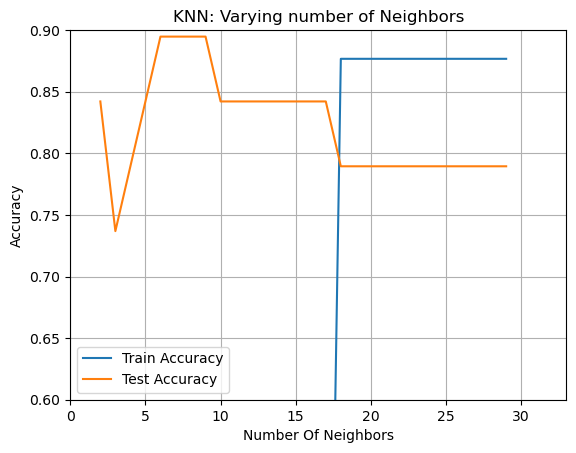

In [ ]:
# Plotting the Train Score and Test Score 
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.60, 0.90)
plt.grid()
plt.show()

In [ ]:
# Finding best parameter ‘k’ for test score 
for key, value in test_score.items():
    if value==max(test_score.values()):
        print(key)
       

6
7
8
9


In [ ]:
# Extract best hyperparameters for n_neighbors
kf=KFold(n_splits=5,shuffle=True,random_state=42)
parameter={'n_neighbors': np.arange(2, 30, 1)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, param_grid=parameter, cv=kf, verbose=1)
knn_cv.fit(X_train_scaled, y_train)
print(knn_cv.best_params_)

{'n_neighbors': 9}

### 4.1.2 Model fitting and testing

In [ ]:
# Using the best parameter from above to train the model and predict
knn2=KNeighborsClassifier(n_neighbors=9)
knn2.fit(X_train_scaled, y_train)
y_pred_knn2=knn2.predict(X_test_scaled)


### 4.1.3 Assessing model performance

In [ ]:
# Print Confusion Matrix 
print(confusion_matrix(y_test, y_pred_knn2))

[[15  0]
 [ 2  2]]


- y_test = 19 variables 
- True negative: 15 (predicted to be no priorirty country and actually no priority country)
- False negative: 2 (predicted to be no priorirty country but actually being priority country)
- False positive: 0 (predicted to be priorirty country but actually no priority country) 
- True positive: 2 (predicted to be priorirty country bactually being priority country) 

In [ ]:
# Print Classification Report
print(classification_report(y_test, y_pred_knn2))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.50      0.67         4

    accuracy                           0.89        19
   macro avg       0.94      0.75      0.80        19
weighted avg       0.91      0.89      0.88        19



- Accuracy = (true positive + true negative) / (ture positive + ture negative + false positive + false negative)
- Precision = true positive / (true positive + falses positive)
- Recall= true positive / (true positive + false negative) 
- F1_score: F1 Score = 2∗ (precision+recall) / (precision∗recall)

- Accuracy for testing dataset after tuning : 89% 
- Precision for prediction of priority countries: 100% -> all predicted priority countries where correct 
- Recall for prediction of priority countries: 50 % -> Half of the priority countries in the testing data set where correctly identified 
- F1-Scorece for prediction of priority countries: 67%



### 4.1.4 Model application

In [ ]:
# Predict the labels for the X_new
y_new_knn = knn2.predict(X_new_scaled)

# Print the predictions
print("Predictions KNN: {}".format(y_new_knn)) 

Predictions KNN: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0]


c:\Users\Oli\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## 4.2 Regression

### 4.2.1 Model fine-tuning

In [ ]:
# Instantiate a Logisitc Regression 'logreg'
logreg = LogisticRegression()
# Print out 'logreg's hyperparameters
print(logreg.get_params())   


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1389495.494373136}
Best score is 0.9304761904761906


### 4.2.2 Model fitting and testing

In [ ]:
# Using the best parameter from above to train the model and predict
logreg2=LogisticRegression(C=1389495.494373136)
logreg2.fit(X_train_scaled, y_train)
y_pred_logreg2=logreg2.predict(X_test_scaled)

### 4.2.3 Assessing model performance

In [ ]:
# Print Confusion Matrix 
print(confusion_matrix(y_test, y_pred_logreg2))

[[12  3]
 [ 2  2]]


- y_test = 19 variables 
- True negative: 12 (predicted to be no priorirty country and actually no priority country)
- False negative: 2 (predicted to be no priorirty country but actually being priority country)
- False positive: 3 (predicted to be priorirty country but actually no priority country) 
- True positive: 2 (predicted to be priorirty country actually being priority country) 

In [ ]:
# Print Classification Report
print(classification_report(y_test, y_pred_logreg2))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.40      0.50      0.44         4

    accuracy                           0.74        19
   macro avg       0.63      0.65      0.64        19
weighted avg       0.76      0.74      0.75        19



- Accuracy for testing dataset after tuning : 74% 
- Precision for prediction of priority countries: 40% -> less than half of the predicted priority countries where correct 
- Recall for prediction of priority countries: 50 % -> Half of the priority countries in the testing data set where correctly identified 
- F1-Score for prediction of priority countries: 44%


### 4.2.4 Model application

In [ ]:
# Predict the labels for the X_new
y_new_logreg = logreg2.predict(X_new_scaled)

# Print the predictions
print("Predictions Logisitc Regression : {}".format(y_new_logreg)) 

Predictions Logisitc Regression : [0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0]


## 4.3 DecisionTreeClassifier()

### 4.3.1 Model fine-tuning

In [ ]:
# Set seed to 1 for reproducibility
SEED = 1
# Instantiate a DecisionTreeClassifier 'dt'
dt = DecisionTreeClassifier(random_state=SEED)
# Print out 'dt's hyperparameters
print(dt.get_params())   


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}


In [ ]:
# Define the grid of hyperparameters 'params_dt'
params_dt = {
            'max_depth': [3, 4,5, 6],
            'min_samples_leaf': [0.04, 0.06, 0.08],
            'max_features': [0.2, 0.4,0.6, 0.8]            
            }

In [ ]:
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,                       
                       scoring='accuracy',                                              
                       cv=10,                       
                       n_jobs=-1)

### 4.3.2 Model fitting and testing

In [ ]:
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train_scaled, y_train)


c:\Users\Oli\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='accuracy')

In [ ]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 0.04}


In [ ]:
# Extract best model from 'grid_dt'
best_model = grid_dt.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test_scaled,y_test)
# Print test set accuracy
print("Test set accuracy of best model: {:.3f}".format(test_acc))


Test set accuracy of best model: 0.789


### 4.3.2 Model fitting and testing

In [ ]:
# Using the best parameter from above to train the model and predict
dt2=DecisionTreeClassifier(max_depth=3, max_features=0.8, min_samples_leaf= 0.04)
dt2.fit(X_train_scaled, y_train)
y_pred_dt2=dt2.predict(X_test_scaled)


### 4.3.3 Assessing model performance

In [ ]:
# Print Confusion Matrix 
print(confusion_matrix(y_test, y_pred_dt2))

[[13  2]
 [ 2  2]]


- y_test = 19 variables 
- True negative: 15 (predicted to be no priorirty country and actually no priority country)
- False negative: 2 (predicted to be no priorirty country but actually being priority country)
- False positive: 0 (predicted to be priorirty country but actually no priority country) 
- True positive: 2 (predicted to be priorirty country and actually being priority country) 

In [ ]:
# Print Classification Report
print(classification_report(y_test, y_pred_dt2))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.50      0.50      0.50         4

    accuracy                           0.79        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.79      0.79      0.79        19



- Accuracy for testing dataset after tuning : 79% 
- Precision for prediction of priority countries: 100% -> all predicted priority countries where correct 
- Recall for prediction of priority countries: 50 % -> Half of the priority countries in the testing data set where correctly identified 
- F1-Scorece for prediction of priority countries: 67%


### 4.3.4 Model application

In [ ]:
# Predict the labels for the X_new
y_new_dt= dt2.predict(X_new_scaled)

# Print the predictions
print("Predictions Decision Tree : {}".format(y_new_dt)) 

Predictions Decision Tree : [1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0]


## 4.4 Evaluating classification Models 

In [ ]:
models = {"Logistic Regression": logreg2,"KNN": knn2, "Decision Tree": dt2}

results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring= "f1")
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

c:\Users\Oli\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Oli\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

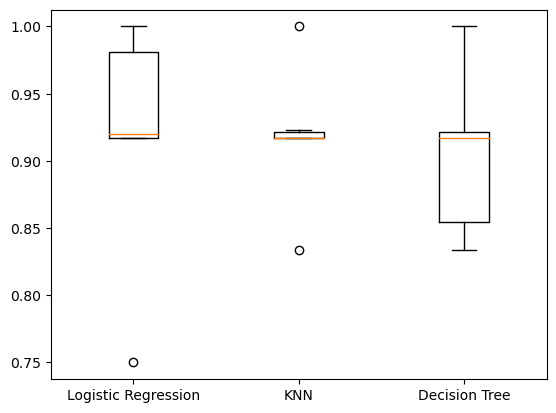

In [ ]:
models = {"Logistic Regression": logreg2,"KNN": knn2, "Decision Tree": dt2}

results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

In [ ]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print("{} Test Set Accuracy: {}".format(name, test_score))

Logistic Regression Test Set Accuracy: 0.7368421052631579
KNN Test Set Accuracy: 0.8947368421052632
Decision Tree Test Set Accuracy: 0.7894736842105263


c:\Users\Oli\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# 5. Model Prediction Visualization

## 5.1 Translate model predictions to countries

In [ ]:
# Add predictions to Dataframe: Sub-Saharan African countries 

ssa_df['Pred_IKIPriorityCountry_KNN'] = y_new_knn
ssa_df['Pred_IKIPriorityCountry_LogReg'] =y_new_logreg
ssa_df['Pred_IKIPriorityCountry_DT'] =y_new_dt

In [ ]:
# Create new dataframe containing only the predictions for Sub-Saharan African countries 

#ssa_df_pred = ssa_df.drop(columns=['RegionName', 'SubregionName','LDC', 'LLDC', 'SIDS', 'Density(P/Km2)', 'LandArea(Km2)', 'GDP', 'Population',
       'Urban_population', 'Fragility_State_Index_Clean', 'GHG_Emissions_2020',
       'GHG_Emissions_1990', 'EPI.new', 'SUM(KBAArea)'])

In [ ]:
# List predicted priority countries according to respective model 
country_prediction_KNN = (ssa_df_pred['CountryName'][ssa_df['Pred_IKIPriorityCountry_KNN'] == 1]).values
country_prediction_LogReg = (ssa_df_pred['CountryName'][ssa_df['Pred_IKIPriorityCountry_LogReg'] == 1]).values
country_prediction_DT = (ssa_df_pred['CountryName'][ssa_df['Pred_IKIPriorityCountry_DT'] == 1]).values
print("Predicted priority countries according to KNN-Model: {}".format(country_prediction_KNN)) 
print("Predicted priority countries according to Logistic Regression Model: {}".format(country_prediction_LogReg)) 
print("Predicted priority countries according to Decision Tree Model: {}".format(country_prediction_DT)) 

Predicted priority countries according to KNN-Model: ['Angola' 'Ethiopia' 'Nigeria' 'Tanzania' 'South Africa']
Predicted priority countries according to Logistic Regression Model: ['Botswana' 'Cameroon' 'Democratic Republic of the Congo' 'Congo'
 'Ethiopia' 'Kenya' 'Mozambique' 'Nigeria' 'Tanzania' 'South Africa']
Predicted priority countries according to Decision Tree Model: ['Angola' "Cote d'Ivoire" 'Democratic Republic of the Congo' 'Ethiopia'
 'Ghana' 'Kenya' 'Madagascar' 'Nigeria' 'Tanzania' 'South Africa']


## 5.2 Show countries on map

In [ ]:
# Create 'world' dataframe by importing geopandas dataset 'naturalearth_lowres'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

C:\Users\Oli\AppData\Local\Temp\ipykernel_3064\2319129041.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
# rename the columns in order to merge with dataframe containing predictions for Sub-Saharan African countries (ssa_df_pred) 
world.columns=['pop_est', 'continent', 'name', 'CountryCode', 'gdp_md_est', 'geometry']
world.head()


In [ ]:
# merge  'world' dataframe with 'ssa_df_pred' dataframe  
merge=pd.merge(world,ssa_df_pred,on='CountryCode')
merge.head()

In [ ]:
# merge again with  location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name').reset_index()


In [ ]:
# Transform POLYGON to POINT
# copy poly to new GeoDataFrame
points = merge.copy()
# change the geometry
points.geometry = points['geometry'].centroid
# same crs
#points.crs = poly.crs
points.head()

In [ ]:
# Filter for Countries that where predicted by one of the three models 
cont = points[points.CountryName.isin(['Angola', 'Botswana', 'Cameroon', 'Congo', "Cote d'Ivoire",  'Democratic Republic of the Congo', 'Ethiopia',  'Ghana', 'Kenya', 'Madagascar',  'Mozambique', 'Nigeria','South Africa', 'Tanzania'])]
contx = cont[['name', 'geometry']]
contx.head()

In [ ]:
# create seperate dataframes for each prediction model

merge_KNN= (merge[merge['Pred_IKIPriorityCountry_KNN'] == 1])
merge_LogReg= (merge[merge['Pred_IKIPriorityCountry_LogReg'] == 1])
merge_DT= (merge[merge['Pred_IKIPriorityCountry_DT'] == 1])

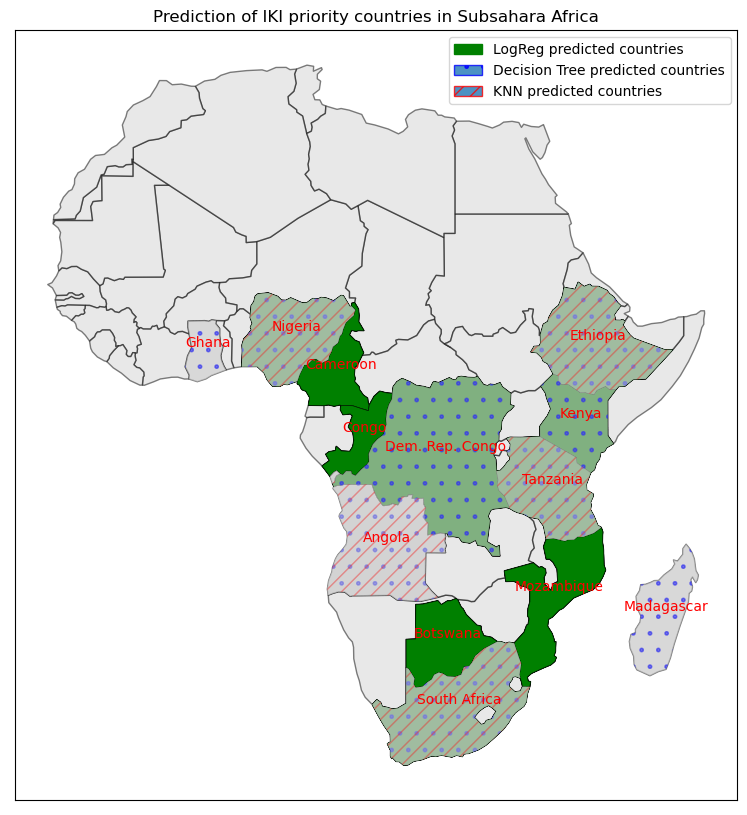

In [ ]:
# Plot African Continent 
# initialize a new figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# grab all African countries
africa = world[world["continent"] == "Africa"]

# plot a basic map of Africa
africa.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

# plot LogReg predicted countries 
for name in merge_LogReg['geometry']:
    merge_LogReg.plot(ax=ax, alpha=0.5, facecolor='green',edgecolor="black", linewidth=0.4)

# plot Decision Tree predicted countries 
for name in merge_DT['geometry']:
    merge_DT.plot(ax=ax, alpha=0.1, facecolor='lightgrey', hatch= '.', edgecolor="blue", linewidth=0)

# plot KNN predicted countries 
for name in merge_KNN['geometry']:
    merge_KNN.plot(ax=ax, alpha=0.1, facecolor='lightgrey',hatch="//", edgecolor="red", linewidth=0, label='KNN predicted countries')


# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# add country names 
for x, y, label in zip(contx.geometry.x, contx.geometry.y, contx.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), alpha=1, textcoords="offset points", ha='center', color='red')


# add legend 
LogReg_patch = mpatches.Patch(color='green', label='LogReg predicted countries')
DT_patch = mpatches.Patch(hatch= '.', edgecolor="blue", alpha=0.8, label='Decision Tree predicted countries')
KNN_patch = mpatches.Patch(hatch= '//', edgecolor="red", alpha=0.8, label='KNN predicted countries')
plt.legend(handles=[LogReg_patch, DT_patch, KNN_patch])

# set the plot title
plt.title("Prediction of IKI priority countries in Subsahara Africa")
plt.show()

## 5.3 Show relevant variables on map 


In [ ]:
# merge  'world' dataframe with 'africa' dataframe  
merge2=pd.merge(world,africa_df,on='CountryCode')

In [ ]:
# merge again with  location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge2=merge2.merge(location,on='name').reset_index()

Text(0.5, 1.0, 'Total GHG Emissions 2020')

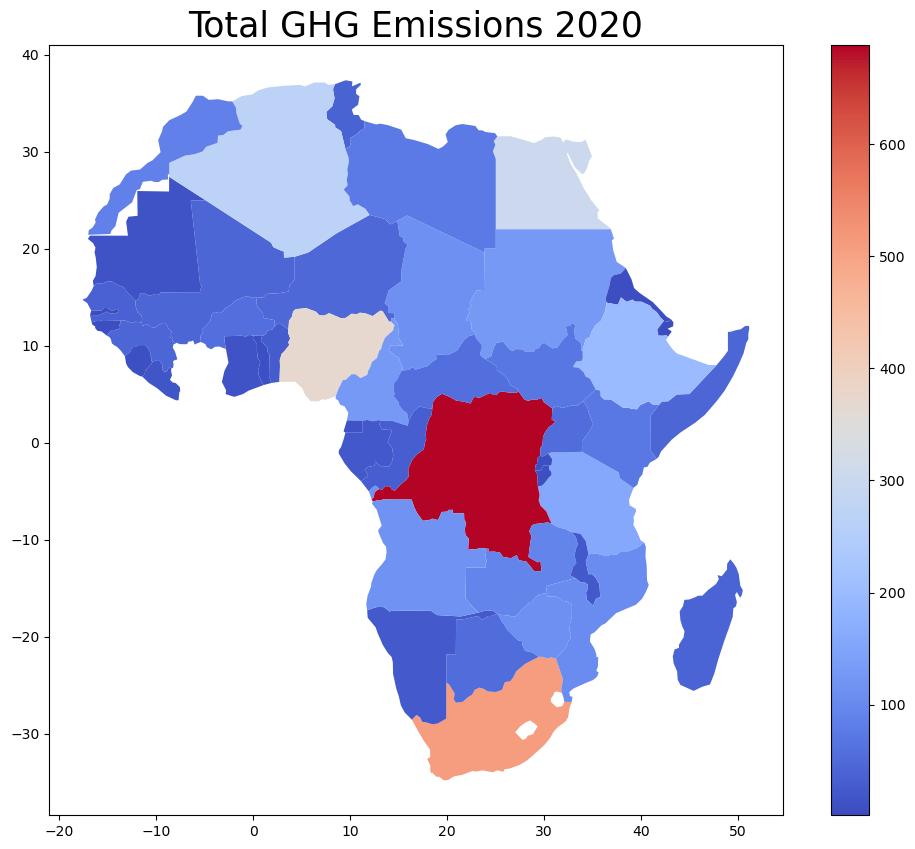

In [ ]:
# plot HG_Emissions_2020 in Africa
merge2.plot(column='GHG_Emissions_2020',
           figsize=(12.5, 10),
           legend=True,cmap='coolwarm')

plt.title('Total GHG Emissions 2020',fontsize=25)

Text(0.5, 1.0, 'Sum of Key Biodiversity Areas')

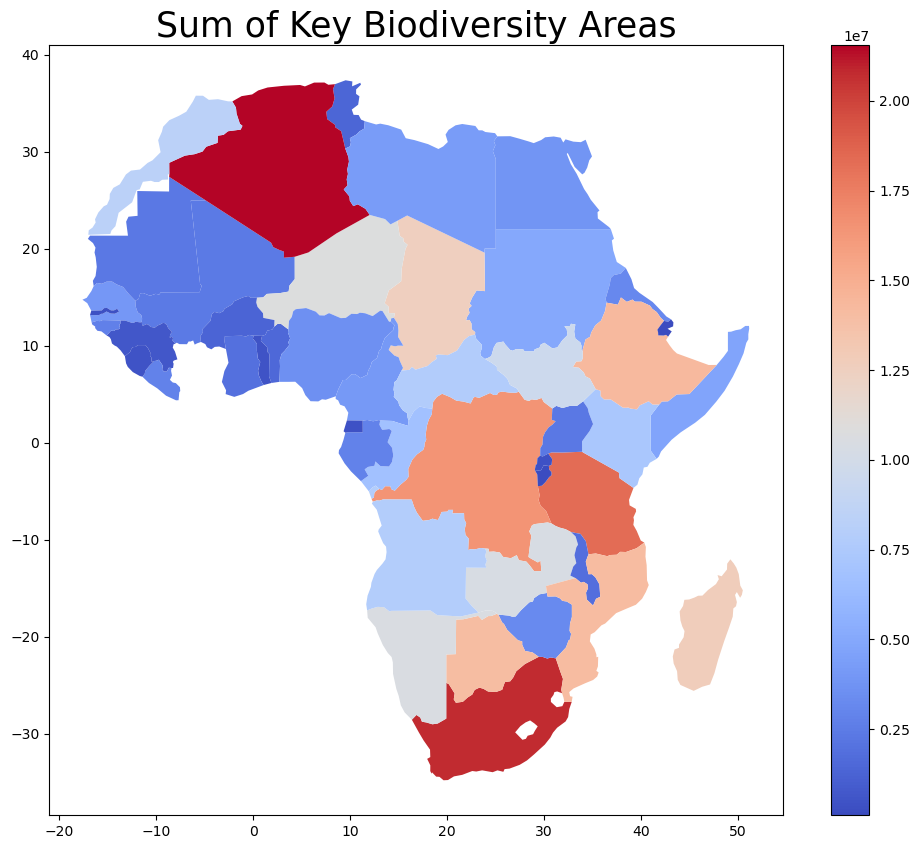

In [ ]:
# plot Key Biodiversity Areas in Africa
merge2.plot(column='SUM(KBAArea)',
           figsize=(12.5, 10),
           legend=True,cmap='coolwarm')

plt.title('Sum of Key Biodiversity Areas',fontsize=25)

Text(0.5, 1.0, 'Fragility State Index')

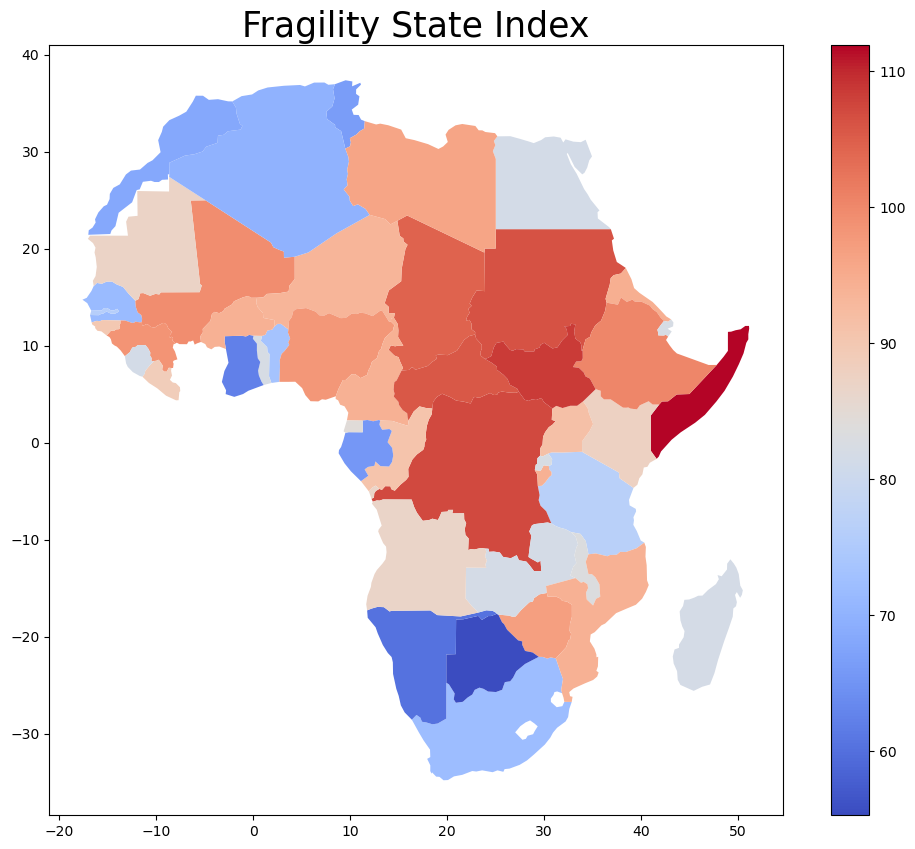

In [ ]:
# plot Fragility State Index in Africa
merge2.plot(column='Fragility_State_Index_Clean',
           figsize=(12.5, 10),
           legend=True,cmap='coolwarm')

# add country names 
for x, y, label in zip(contx.geometry.x, contx.geometry.y, contx.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), alpha=1, textcoords="offset points", ha='center', color='red')

plt.title('Fragility State Index',fontsize=25)

